Calculate the residuals and output all the predictions into


In [1]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import os
from variables import SDG_MAP

In [2]:
# Gets SDG 1 to 16 predictions for project prediction files
# PROJECT_NAME = "all_undergrad_excel"
PROJECT_NAME = "2023_all_ugrad_outlines"
paths = glob(
    f"../data/predictions/*-logistic_regression-{PROJECT_NAME}-raw__predictions.jsonl"
)
ref_path = f"../data/raw/{PROJECT_NAME}.jsonl"
ref_data = pd.read_json(ref_path, lines=True)

# Establish folder
folder_path = f"../data/formatted_outputs/{PROJECT_NAME}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [3]:
combined = []
for path in paths:
    data = pd.read_json(path, lines=True)
    data = data.merge(ref_data, left_index=True, right_index=True)
    combined.append(data)

combined = pd.concat(combined)
combined.drop(["text_y", "index"], axis="columns", inplace=True)
combined.rename(columns={"text_x": "text"}, inplace=True)

def save_per_faculty(combined):
    combined["cats"] = combined["cats"].apply(lambda l: [SDG_MAP[x] for x in l])

    aggregated_preds = []
    for i, group in combined.groupby("CRSE_ID"):
        aggregated_predictions = list(group["prediction"])
        example_row = group.iloc[0]
        example_row["prediction"] = aggregated_predictions
        aggregated_preds.append(example_row)

    aggregated_preds = pd.DataFrame(aggregated_preds)

    # Save jsonl for each faculty
    for faculty, group in aggregated_preds.groupby("FACULTY DESC"):
        group.to_json(f"{folder_path}/{faculty}.jsonl", orient="records", lines=True)


save_per_faculty(combined)

C:\Users\arman\AppData\Local\Temp\ipykernel_376\2755461233.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example_row["prediction"] = aggregated_predictions


In [4]:
def get_pred_details(row):
    try:
        pred_info = row["prediction"]
        SDG = pred_info["category"]
        pred = pred_info["prediction"]
        conf = pred_info["metadata"]["confidence"]
    except Exception as e:
        print(row)

    return SDG, pred, conf


combined["SDG"], combined["pred"], combined["confidence"] = zip(
    *combined.apply(get_pred_details, axis=1)
)
combined["sdg_name"] = combined["SDG"].apply(lambda x: SDG_MAP[x])

In [5]:
def calculate_residuals(df):
    residuals = []
    for i, row in df.iterrows():
        ref_value = row["original_label"]
        pred = row["pred"]
        confidence = row["confidence"]

        if pred != ref_value:
            confidence = 1 - confidence

        residual = round(1 - confidence, 2)
        residuals.append(residual)

    return residuals


# Low residuals == more coherence
# High residuals == less coherence
combined["residuals"] = calculate_residuals(combined)

In [6]:
def save_info(combined, PROJECT_NAME):
    # Save all the residuals
    order = [
        "STRM",
        "FACULTY DESC",
        "DEPARTMENT",
        "CRSE CAREER",
        "SSR COMPONENT",
        "CRSE_ID",
        "COURSE CODE",
        "CATALOG NBR",
        "CLASS SECTION",
        "CLASS DESCR",
        "ENROLMENT",
        "LAST TERM OFFERED",
        "URL",
        "has_sdg",
        "labels",
        "SDG",
        "sdg_name",
        "original_label",
        "pred",
        "comparison",
        "confidence",
        "residuals",
    ]

    additional_order = [
        "text",
        "prediction",
        "entities",
        "cats",
    ]

    column_mapping = {
        "labels": "all_human_labels",
        "pred": "model_prediction",
        "original_label": "human_prediction",
        "confidence": "model_confidence",
    }

    combined = combined[order + additional_order]
    combined.columns = [column_mapping.get(col, col) for col in combined.columns]
    combined[[col for col in combined.columns if col not in additional_order]].to_excel(
        f"{folder_path}/residuals.xlsx", index=False
    )


save_info(combined, PROJECT_NAME)

In [7]:
def graph_boxplot(df, stratify_by="DEPARTMENT", hue=None):
    grouped = df.groupby([stratify_by])["residuals"].median().sort_values().index
    sns.boxplot(df, x="residuals", y=stratify_by, order=grouped, hue=hue)
    plt.show()

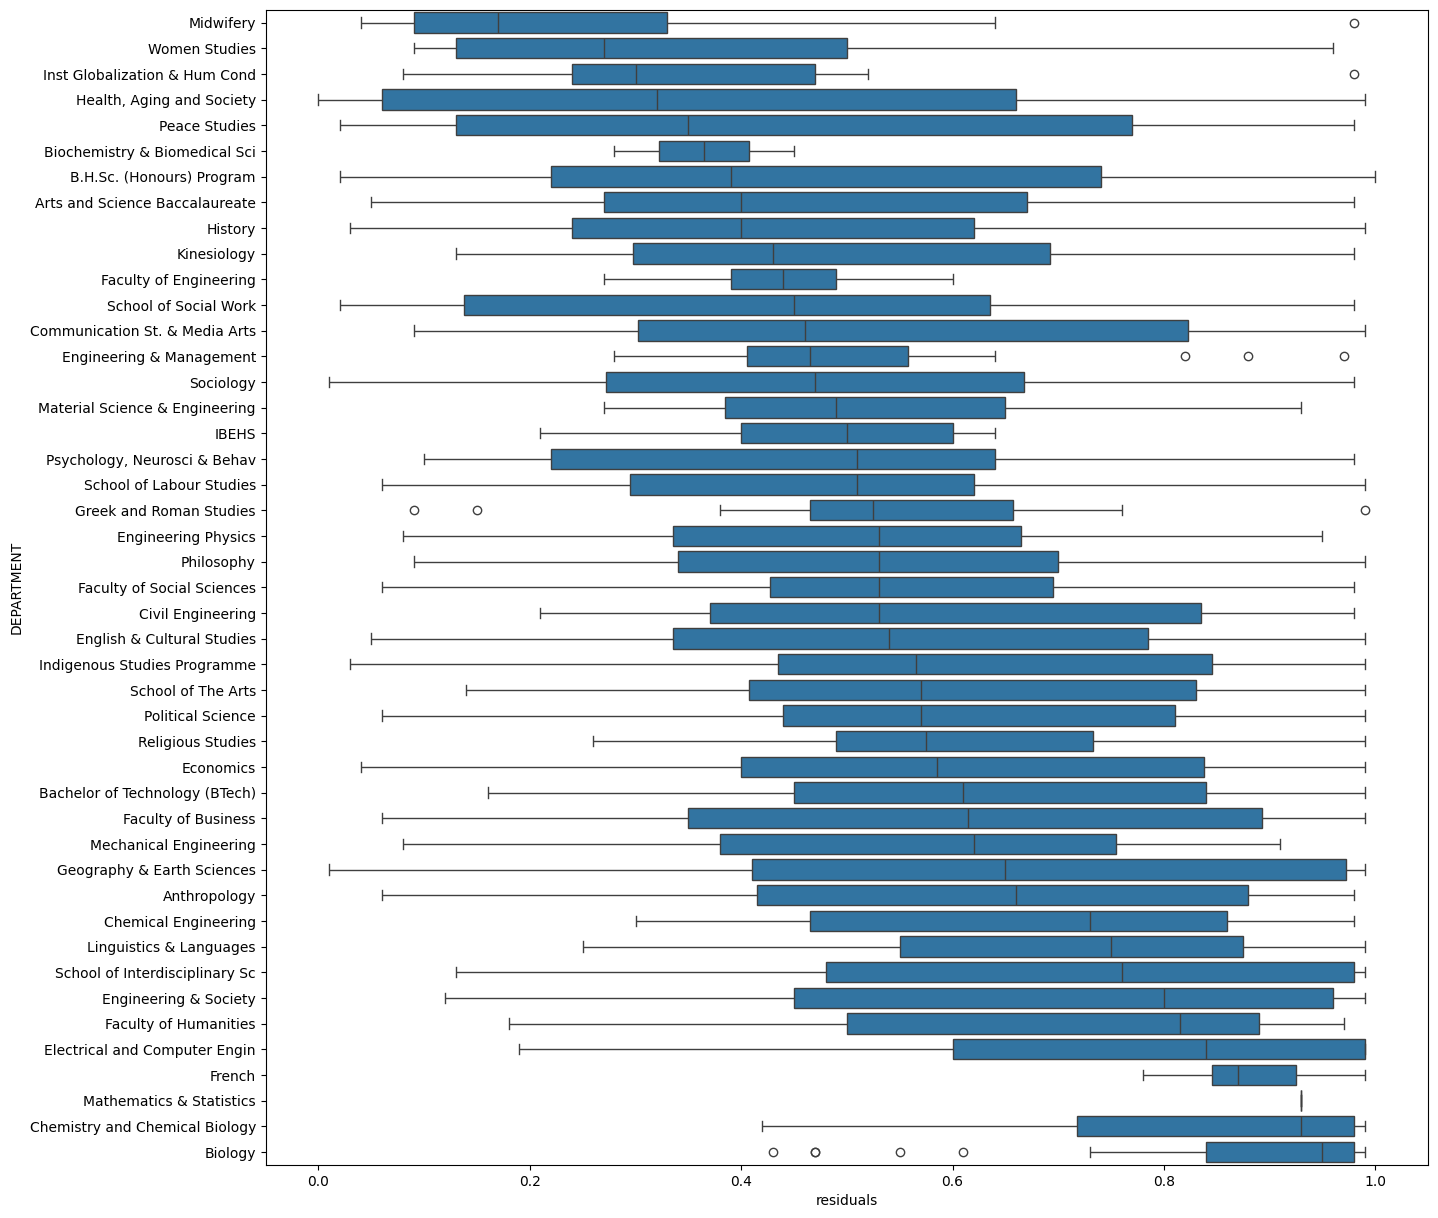

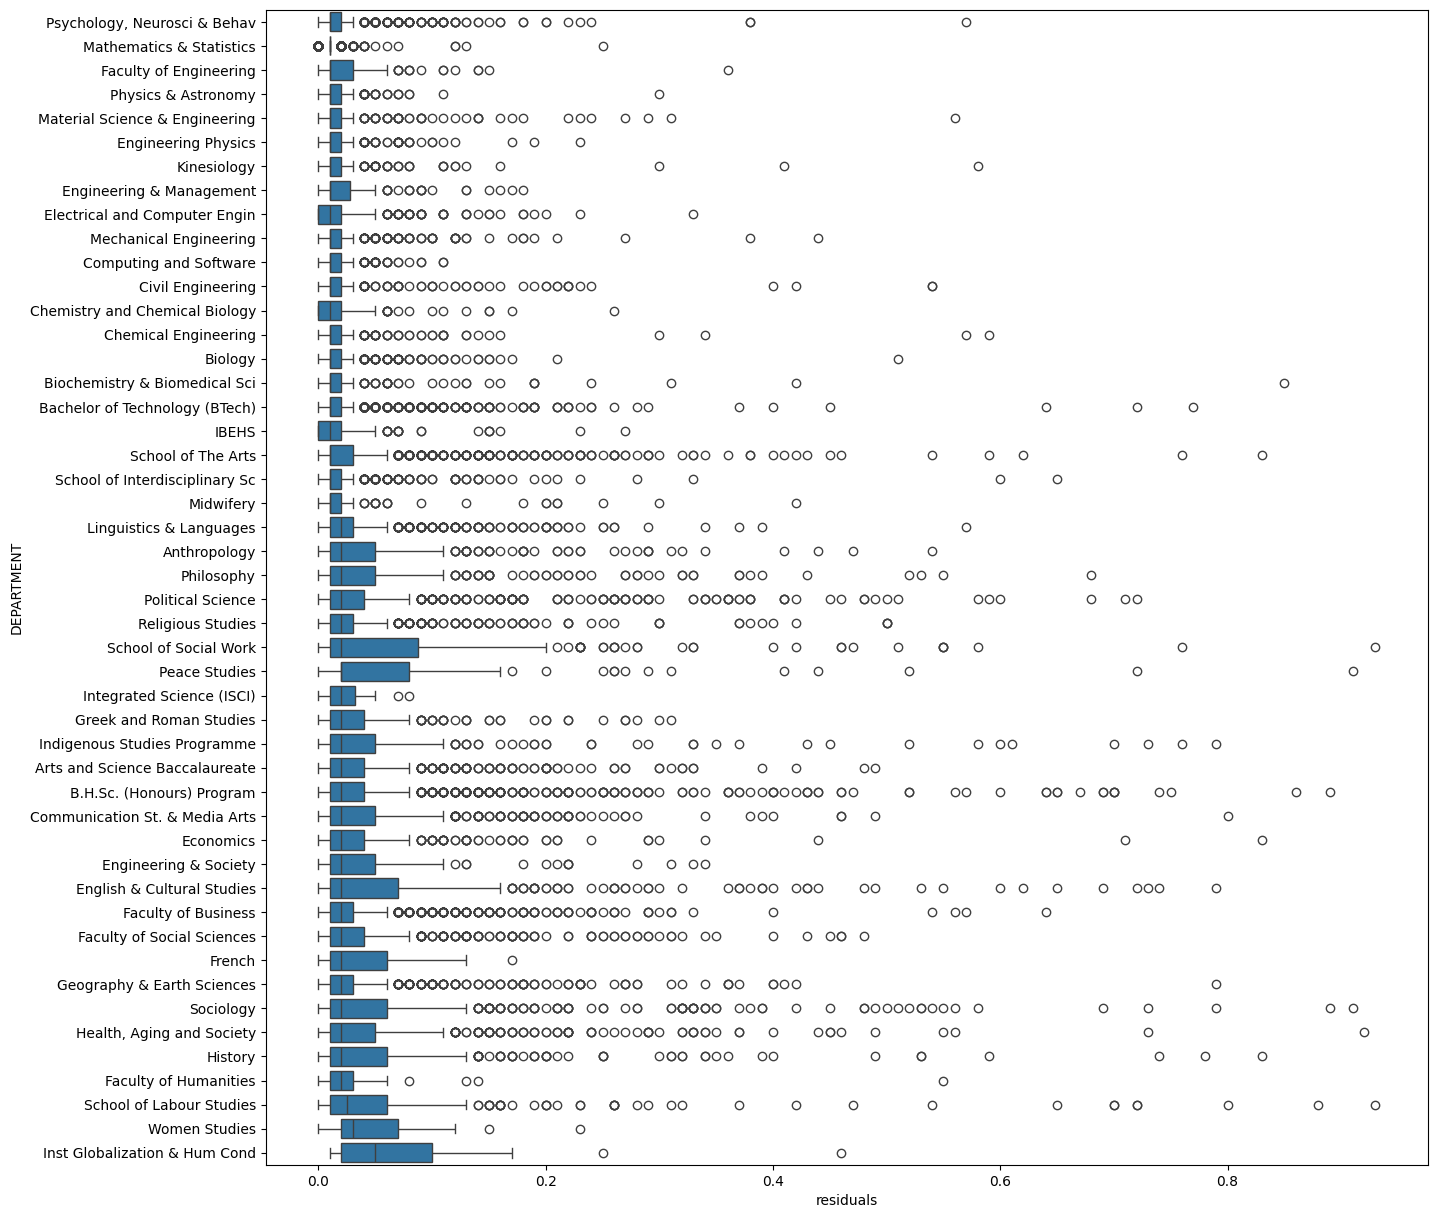

HUMAN PREDICTION: 0
MODEL PREDICTION: 0


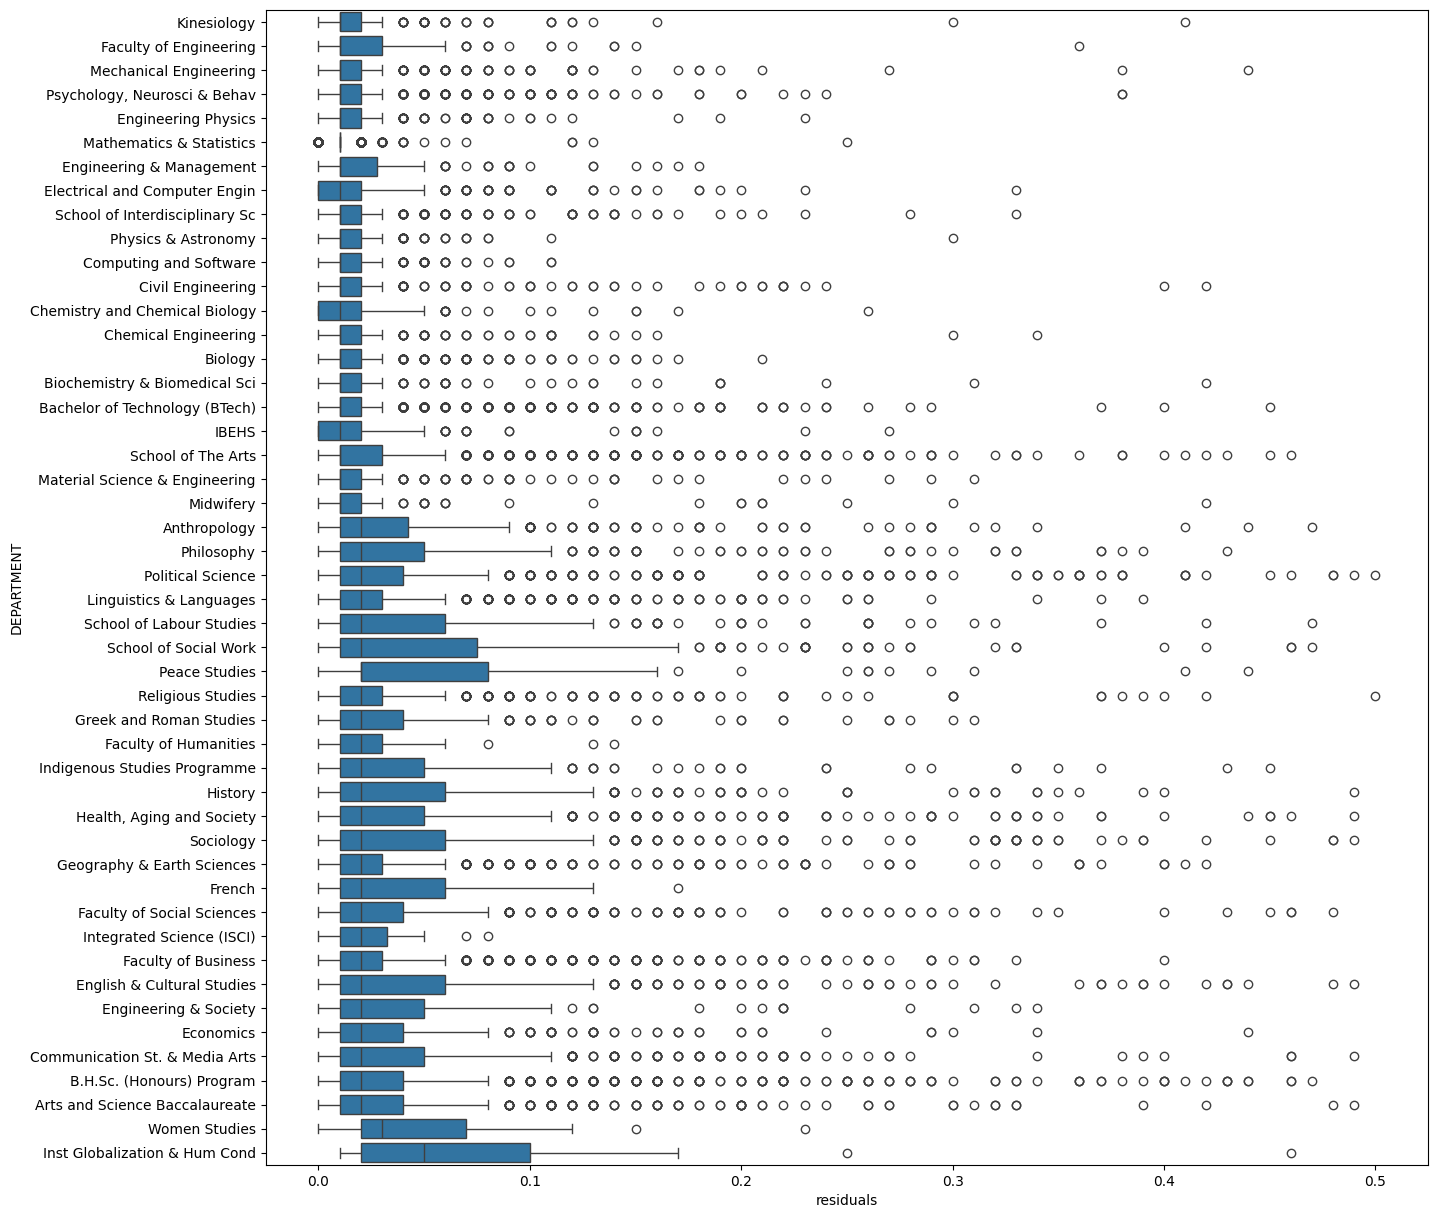

HUMAN PREDICTION: 0
MODEL PREDICTION: 1


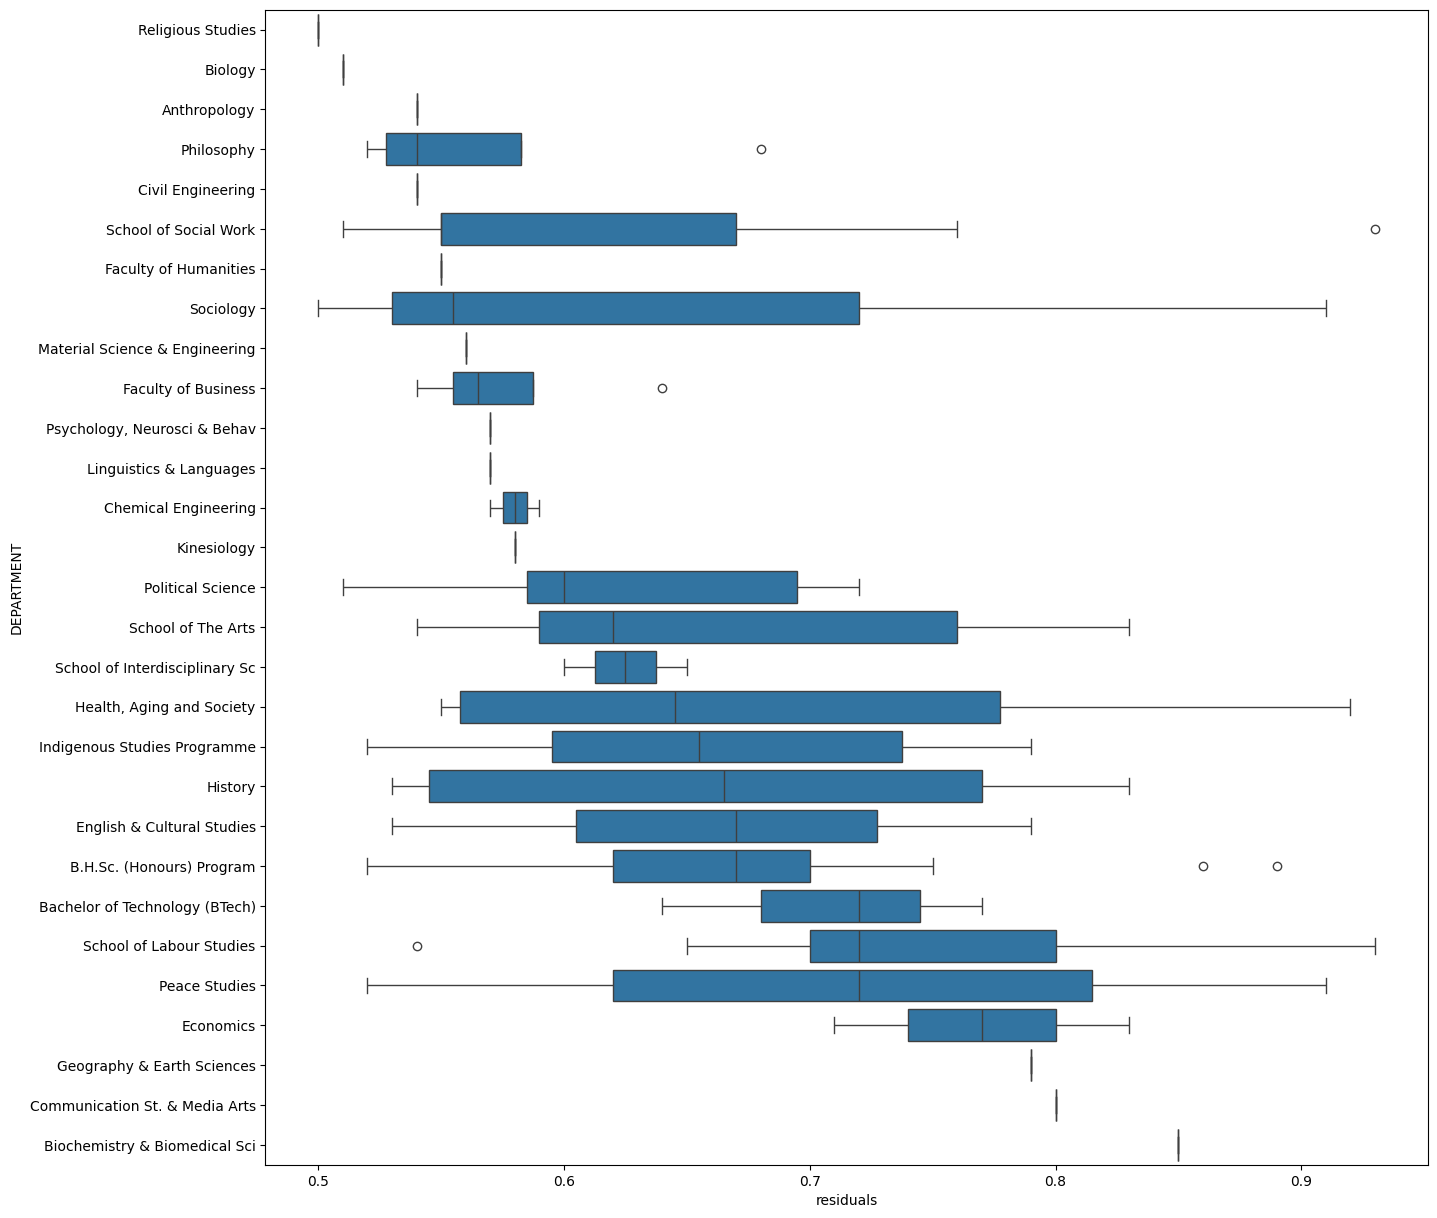

HUMAN PREDICTION: 1
MODEL PREDICTION: 1


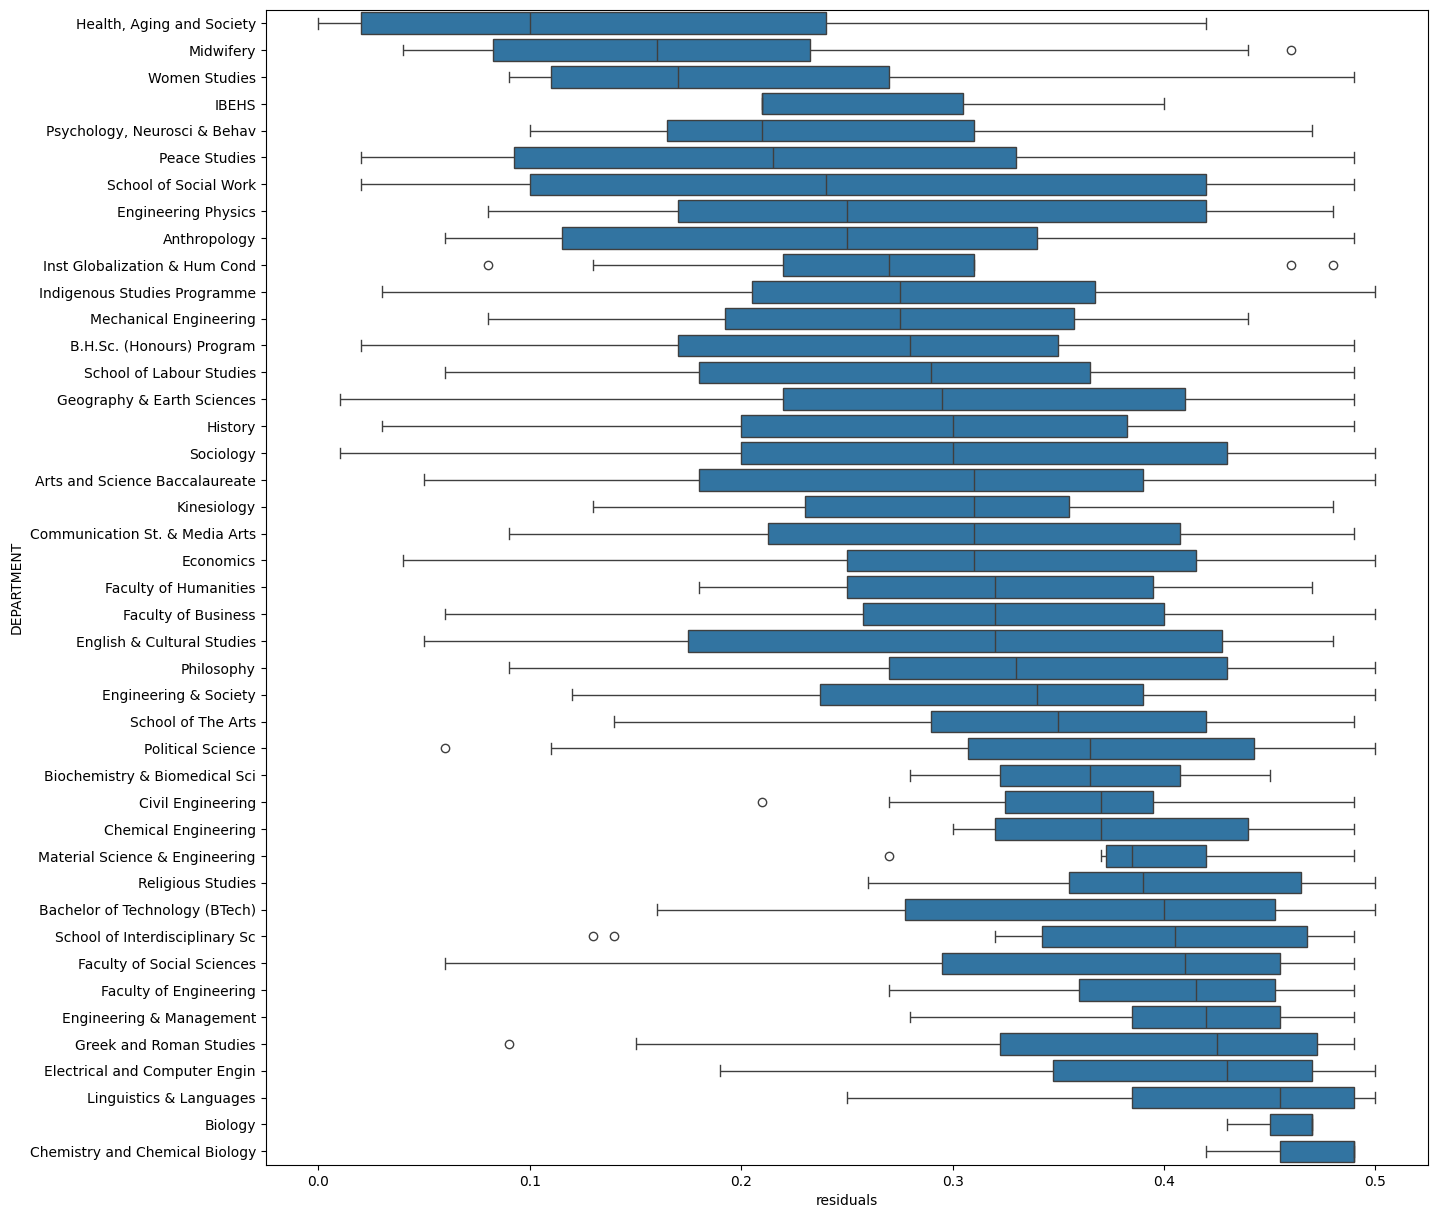

HUMAN PREDICTION: 1
MODEL PREDICTION: 0


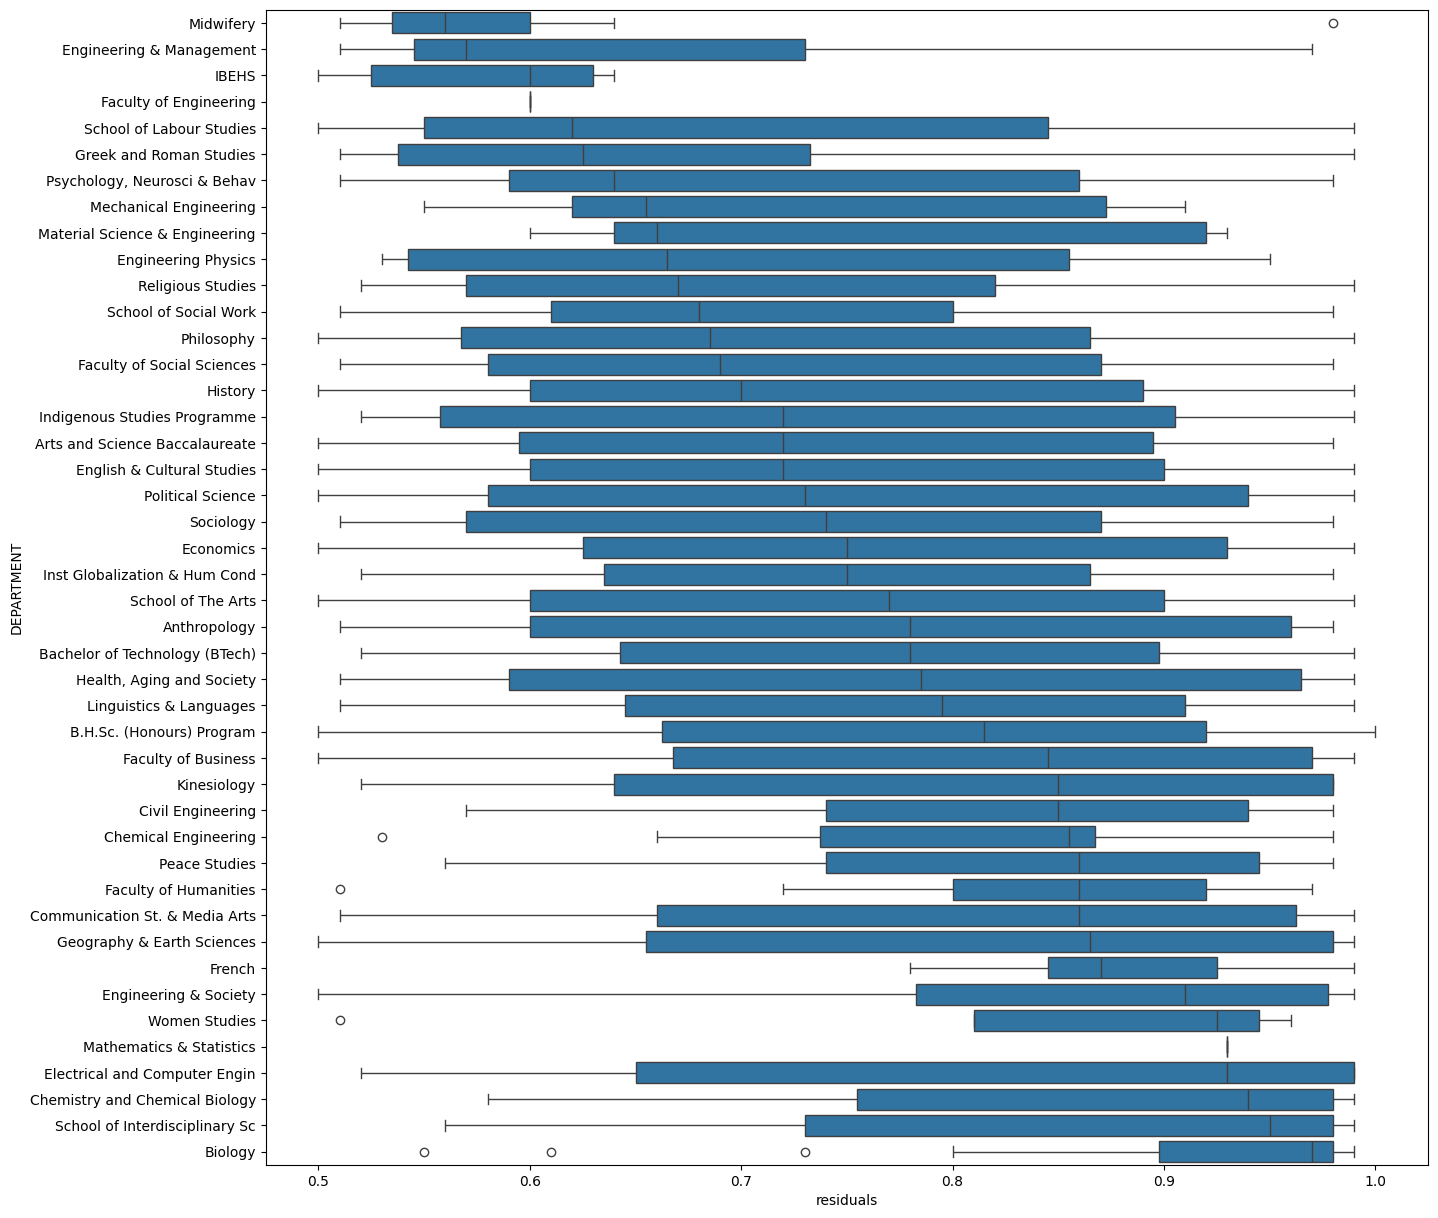

In [8]:
# Make (human, model) combinations to graph
fig = plt.figure(figsize=(15, 15))
graph_boxplot(combined[combined["original_label"] != 0], stratify_by="DEPARTMENT")
fig = plt.figure(figsize=(15, 15))
graph_boxplot(combined[combined["original_label"] != 1], stratify_by="DEPARTMENT")

combinations = [(0, 0), (0, 1), (1, 1), (1, 0)]
for human_pred, model_pred in combinations:
    fig = plt.figure(figsize=(15, 15))
    print(f"HUMAN PREDICTION: {human_pred}\nMODEL PREDICTION: {model_pred}")
    graph_boxplot(
        combined[
            (combined["original_label"] == human_pred)
            & (combined["pred"] == model_pred)
        ],
        stratify_by="DEPARTMENT",
    )